In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:

# 1. LOAD DATA
df = pd.read_csv("//Users//tshephangchepete//Downloads//PD//sales_dataset.csv")

In [3]:
# 2. FILTER TO PURCHASES AND RELEVANT FIELDS
df = df[df['Action'] == 'PURCHASE'].copy()
df = df[(df['Country'].notna()) & (df['Product'].notna())]
df = df[['Country', 'Product', 'Quantity', 'Total_Price', 'Profit', 'Sales_Channel']]
df

,Country,Product,Quantity,Total_Price,Profit,Sales_Channel
0,Scotland,Rapid Prototyping Basic,1,800.0,450.0,Referral
1,Germany,Rapid Prototyping Advanced,3,6000.0,3600.0,Referral
2,Scotland,Rapid Prototyping Basic,1,800.0,450.0,Direct
4,Belgium,Rapid Prototyping Basic,1,800.0,450.0,Website
5,Scotland,Employee Experience Suite,1,2500.0,1500.0,Social Media
...,...,...,...,...,...,...
499994,Ireland,DEX Analytics,5,3000.0,1750.0,Referral
499995,France,Rapid Prototyping Basic,1,800.0,450.0,Direct
499997,Scotland,AI Assistant Enterprise,5,6500.0,4500.0,Website
499998,Germany,AI Assistant Pro,3,1500.0,900.0,Social Media


In [4]:
# 3. ENCODE CATEGORICAL FEATURES
le_country = LabelEncoder()
le_product = LabelEncoder()
le_channel = LabelEncoder()
df['Country_enc'] = le_country.fit_transform(df['Country'])
df['Product_enc'] = le_product.fit_transform(df['Product'])
df['Sales_Channel_enc'] = le_channel.fit_transform(df['Sales_Channel'])

In [5]:
# 4. SELECT FEATURES - Pick the best feature to avoid overfitting
# Let's examine which single feature gives the best accuracy
features = ['Quantity', 'Total_Price', 'Profit', 'Sales_Channel_enc', 'Country_enc']
results = {}
target = 'Product_enc'

In [6]:
for feature in features:
    X = df[[feature]]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
    rf = RandomForestClassifier(random_state=42, n_estimators=100)
    rf.fit(X_train, y_train)
    acc = rf.score(X_test, y_test)
    results[feature] = acc

In [7]:
best_feature = max(results, key=results.get)
print("Best single feature for product prediction (least overfit):", best_feature)

Best single feature for product prediction (least overfit): Total_Price


In [8]:
# 5. PREPARE DATA FOR MODEL COMPARISON
X = df[[best_feature, 'Country_enc']] 
y = df[target]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

In [11]:
model_results = {}

In [12]:
for name, model in models.items():
    if name == "Logistic Regression":  # SVM & KNN benefit from scaling
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    model_results[name] = {
        'accuracy': acc,
        'confusion_matrix': cm,
        'classification_report': cr,
        'y_pred': y_pred
    }
    print(f"\n{name} accuracy: {acc:.4f}")


Logistic Regression accuracy: 0.4156

Random Forest accuracy: 0.9422

K-Nearest Neighbors accuracy: 0.9279


/var/folders/p7/lf_hf2p57yx0km6g5ngp7sr00000gn/T/ipykernel_29170/740597814.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(models.keys()), y=accs, palette="viridis")


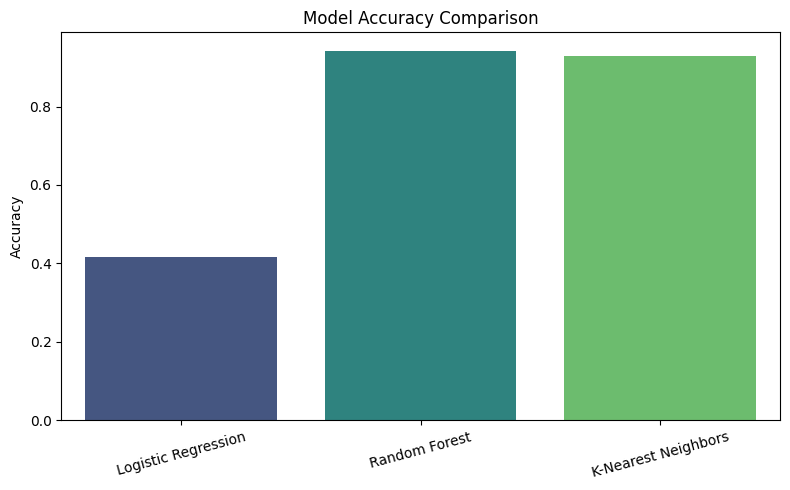

In [13]:
accs = [model_results[m]['accuracy'] for m in models]
plt.figure(figsize=(8,5))
sns.barplot(x=list(models.keys()), y=accs, palette="viridis")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

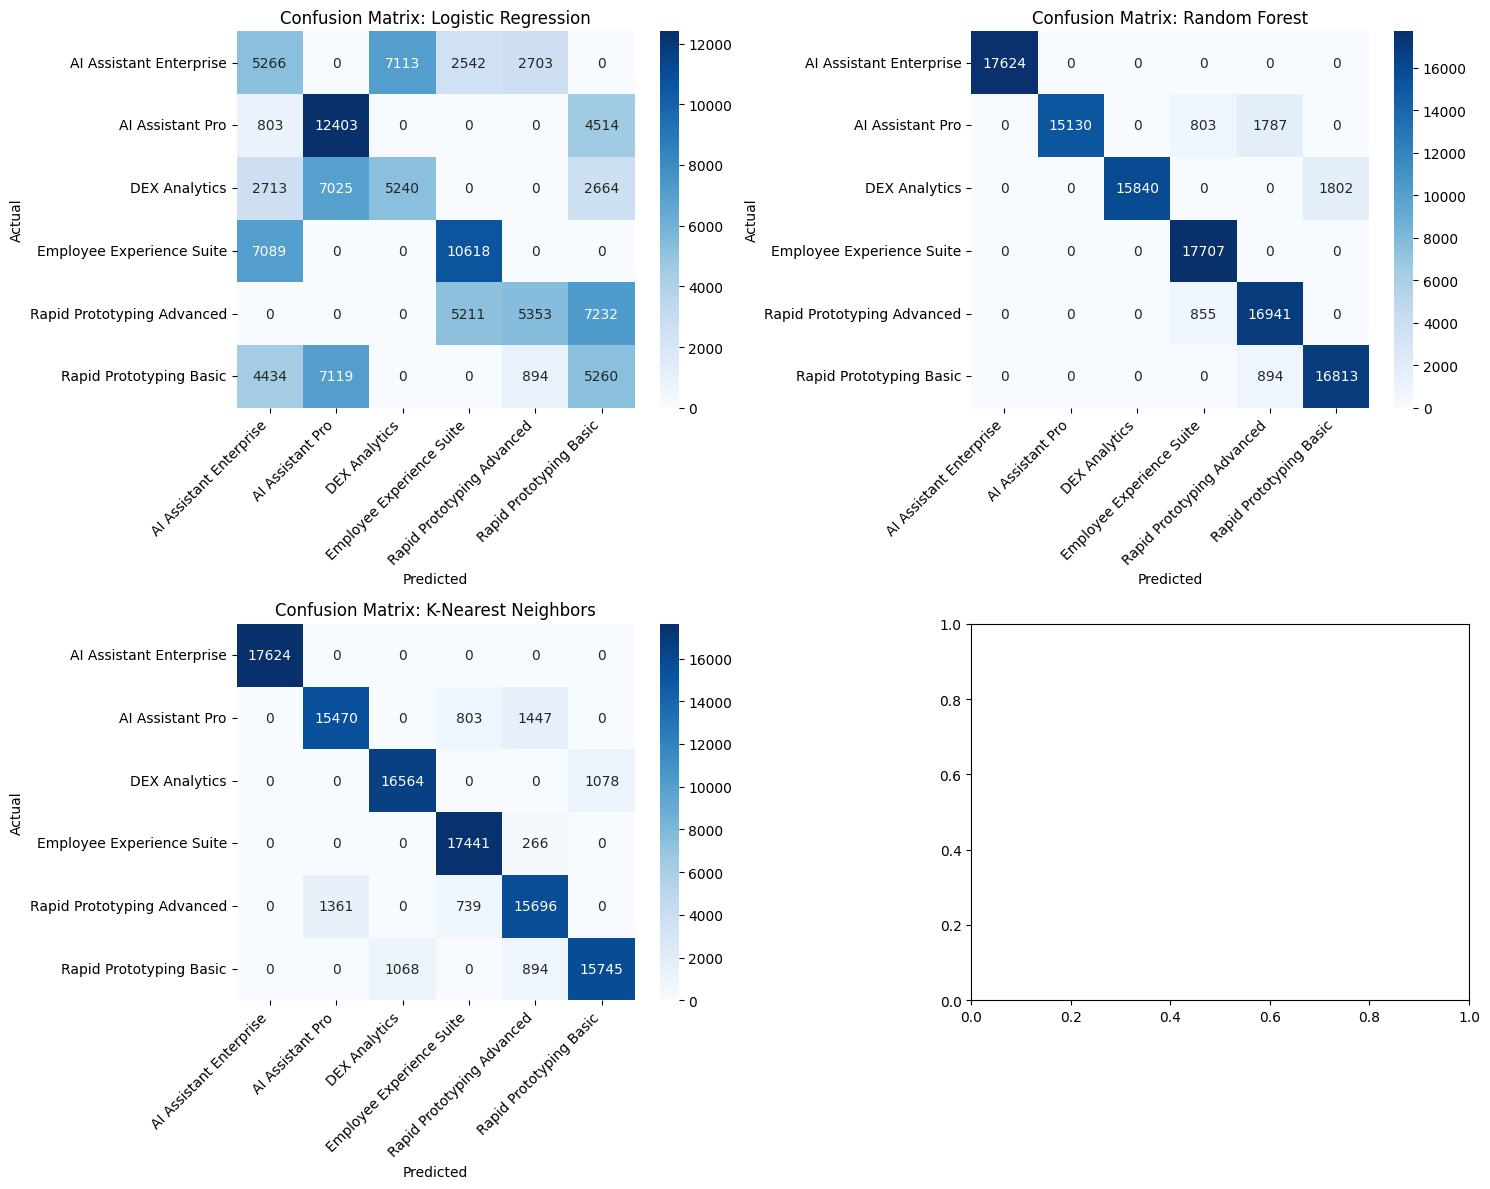

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(15,12))
axes = axes.flatten()
for idx, (name, result) in enumerate(model_results.items()):
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', ax=axes[idx], cmap="Blues")
    axes[idx].set_title(f"Confusion Matrix: {name}")
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xticklabels(le_product.classes_, rotation=45, ha='right')
    axes[idx].set_yticklabels(le_product.classes_, rotation=0)
plt.tight_layout()
plt.show()

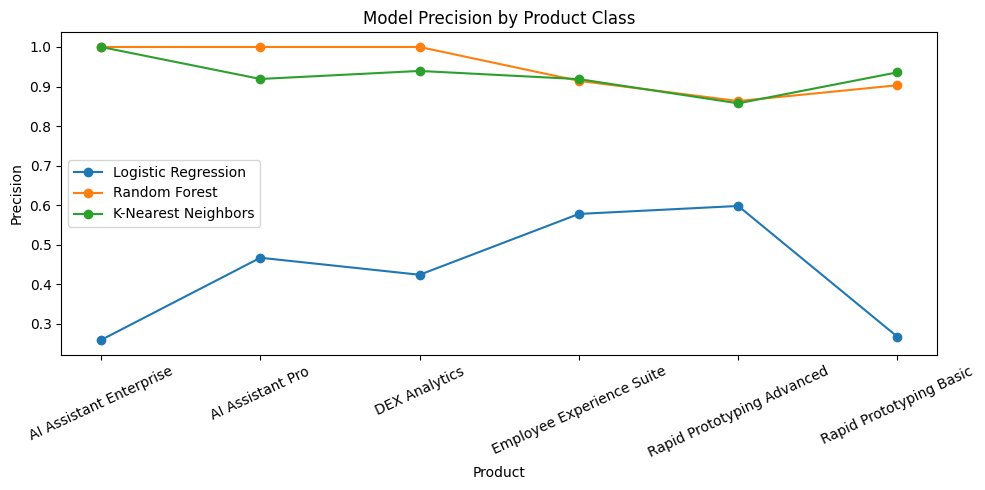

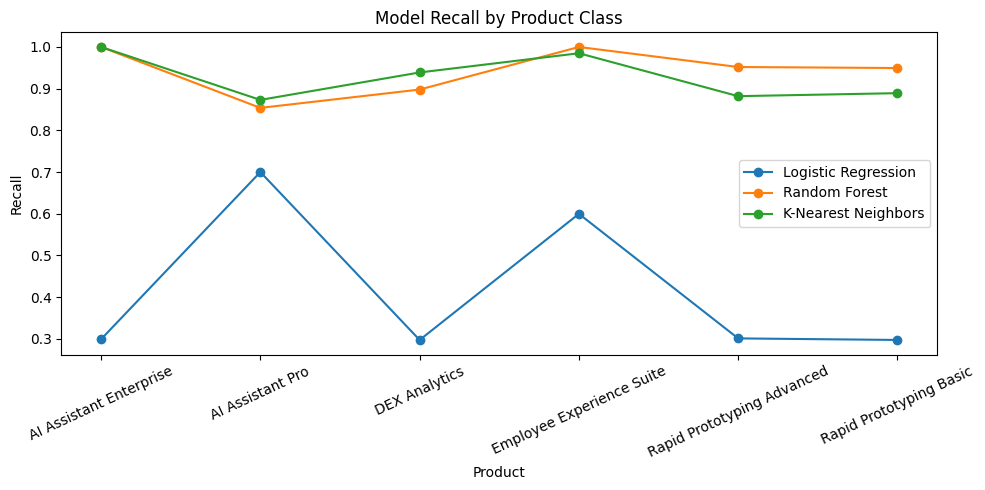

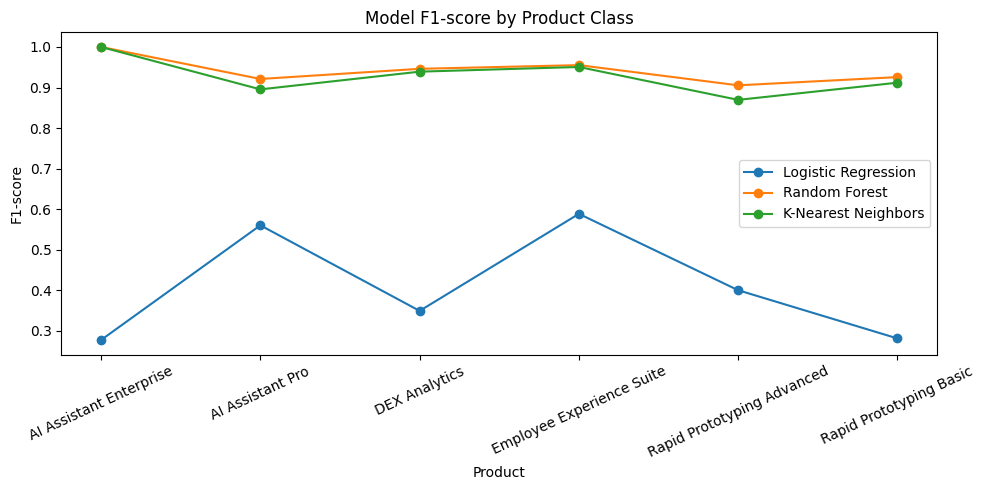

In [15]:
metrics = ['precision', 'recall', 'f1-score']
for metric in metrics:
    plt.figure(figsize=(10,5))
    for name, result in model_results.items():
        cr_df = pd.DataFrame(result['classification_report']).transpose()
        # Get only the class entries (exclude avg/total rows)
        class_labels = [str(i) for i in range(len(le_product.classes_))]
        cr_df = cr_df.loc[class_labels]
        cr_df.index = le_product.classes_
        plt.plot(le_product.classes_, cr_df[metric], marker='o', label=name)
    plt.title(f"Model {metric.capitalize()} by Product Class")
    plt.ylabel(metric.capitalize())
    plt.xlabel("Product")
    plt.legend()
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()

In [16]:
best_model = max(model_results, key=lambda k: model_results[k]['accuracy'])
print(f"\nBest model: {best_model} (Accuracy: {model_results[best_model]['accuracy']:.4f})")


Best model: Random Forest (Accuracy: 0.9422)


In [17]:
if best_model == "Logistic Regression":
    model = models[best_model]
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
else:
    model = models[best_model]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

# Print confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le_product.classes_))

Confusion Matrix:
[[17624     0     0     0     0     0]
 [    0 15130     0   803  1787     0]
 [    0     0 15840     0     0  1802]
 [    0     0     0 17707     0     0]
 [    0     0     0   855 16941     0]
 [    0     0     0     0   894 16813]]

Classification Report:
                            precision    recall  f1-score   support

   AI Assistant Enterprise       1.00      1.00      1.00     17624
          AI Assistant Pro       1.00      0.85      0.92     17720
             DEX Analytics       1.00      0.90      0.95     17642
 Employee Experience Suite       0.91      1.00      0.96     17707
Rapid Prototyping Advanced       0.86      0.95      0.91     17796
   Rapid Prototyping Basic       0.90      0.95      0.93     17707

                  accuracy                           0.94    106196
                 macro avg       0.95      0.94      0.94    106196
              weighted avg       0.95      0.94      0.94    106196

